In [5]:
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
tf.set_random_seed(42)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
           
import keras.backend.tensorflow_backend as K

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras.layers import Input, merge, Concatenate, concatenate
from keras.models import load_model

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from utils import load_data

np.random.seed(42)

In [6]:
IMAGE_WIDTH = 29  # x - phi
IMAGE_HEIGHT = 15  # y - eta


In [36]:
x_data, y_data, mva_data = load_data(inputdir="outputs/",nevents=3000000)

Loaded outputs/data_1.npz
Loaded outputs/data_10.npz
Loaded outputs/data_100.npz
Loaded outputs/data_101.npz
Loaded outputs/data_102.npz
Loaded outputs/data_103.npz
Loaded outputs/data_104.npz
Loaded outputs/data_105.npz
Loaded outputs/data_106.npz
Loaded outputs/data_107.npz
Loaded outputs/data_108.npz
Loaded outputs/data_109.npz
Loaded outputs/data_11.npz
Loaded outputs/data_110.npz
Loaded outputs/data_111.npz
Loaded outputs/data_12.npz
Loaded outputs/data_13.npz
Loaded outputs/data_14.npz
Loaded outputs/data_15.npz
Loaded outputs/data_16.npz
Loaded 21 files with 3000000 events


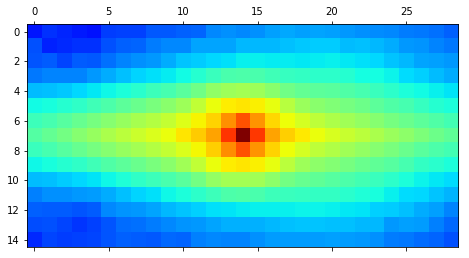

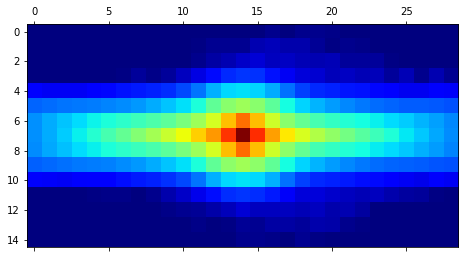

In [37]:
sum_imgs_bg = x_data[(y_data[:,0]<2)].sum(0)
sum_imgs_sig = x_data[(y_data[:,0]==2)].sum(0)
sum_imgs_bg /= sum_imgs_bg.max()
sum_imgs_sig /= sum_imgs_sig.max()
plt.matshow(sum_imgs_bg, norm=LogNorm(vmin=1.e-5, vmax=1), cmap='jet')
plt.matshow(sum_imgs_sig, norm=LogNorm(vmin=1.e-5, vmax=1), cmap='jet')

In [38]:
def plot_pts(truth, pts, etas, weights=None, bins=None,logx=True,logy=True,compute_sfs=False):
    crange = (5.,300)
    is_sig = truth == 2
    fig, axs = plt.subplots(1,3,figsize=(16,3.5))
    if bins is None:
        bins = np.array(range(5,78,2)+range(80,200,5)+range(200,300,10)+range(300,500,100)+range(500,1000+1,500)+[4000])

    all_sfs = np.ones(len(pts))
    for whicheta, etalabel in [
        [0,"$|\\eta|<0.8$"],
        [1,"$0.8<|\\eta|<1.479$"],
        [2,"$1.479<|\\eta|<2.5$"]
    ]:
        etarange = np.ones(len(etas))>0
        if whicheta == 0:
            etarange = (np.abs(etas) > 0.)    & (np.abs(etas) < 0.8)
        elif whicheta == 1:
            etarange = (np.abs(etas) > 0.8)   & (np.abs(etas) < 1.479)
        elif whicheta == 2:
            etarange = (np.abs(etas) > 1.479) & (np.abs(etas) < 2.5)

        sig_pt = pts[is_sig & etarange]
        bkg_pt = pts[(~is_sig) & etarange]
        if len(sig_pt) < 1: continue
        weights_bkg, weights_sig = None, None
        if weights is not None:
            weights_bkg = weights[~is_sig & etarange]
        counts_bkg, _, _ = axs[whicheta].hist(bkg_pt,range=crange,bins=bins, weights=weights_bkg, histtype="step", lw=2,label="bkg")
        counts_sig, _, _ = axs[whicheta].hist(sig_pt,range=crange,bins=bins, weights=weights_sig, histtype="step", lw=2,label="signal")
        if logx: axs[whicheta].set_xscale("log", nonposy='clip')
        if logy: 
            axs[whicheta].set_yscale("log", nonposy='clip')
            axs[whicheta].set_ylim([0,np.max(counts_bkg)*1.2])
        axs[whicheta].set_title(etalabel)
        axs[whicheta].legend()
    
        if compute_sfs:
            sfs = counts_sig/counts_bkg
            sfs[~np.isfinite(sfs)] = 0.
            all_sfs[etarange & (~is_sig)] = sfs[np.digitize(bkg_pt,bins)-1]
    
    return bins,all_sfs
    


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


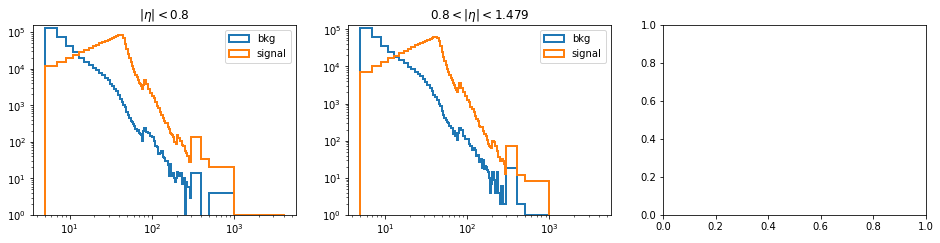

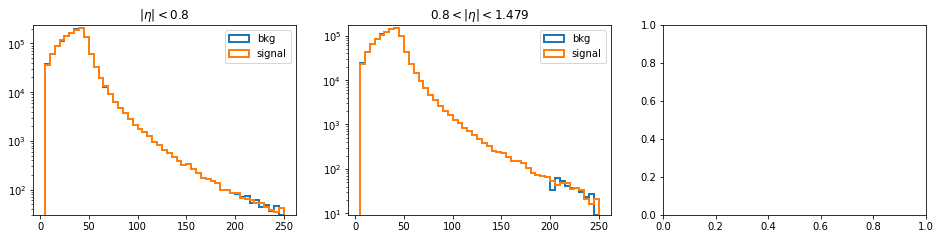

In [39]:

truth = y_data[:,0]
pts = y_data[:,1]
etas = y_data[:,2]
# plot the pt distributions and get sfs the first time
bins, weights = plot_pts(truth,pts,etas,compute_sfs=True)
# use these weights event-by-event and plot in more appealing binning
_ = plot_pts(truth,pts,etas,weights=weights,bins=np.linspace(5,250,50),logx=False,logy=True)

In [40]:

# make extra/aux inputs and scale them
aux_data = y_data[:,[4,5]] # seed iphi, seed ieta
# aux_data = y_data[:,[1,4,5]] # pt, seed iphi, seed ieta
extra_data = y_data[:,6] # PU, 
# print "FIXME"
# aux_data = np.c_[aux_data, y_data[:,0]] # FIXME NOTE THIS IS INJECTING TRUTH INFORMATION!!!!
scaler = MinMaxScaler()
aux_data = scaler.fit_transform(aux_data)

# take the first col from y_data (class label)
y_data_class = np.copy(y_data[:,0])
y_data_class[y_data_class<2] = 0
y_data_class[y_data_class==2] = 1
x_train, x_test, y_train, y_test, aux_train, aux_test, extra_train, extra_test, weights_train, weights_test = \
  train_test_split(x_data, y_data_class, aux_data, extra_data, weights, test_size=0.3, random_state=42)
print "Training samples: ", x_train.shape[0]
print "Testing samples: ", x_test.shape[0]

# reshape
x_train = x_train.reshape(x_train.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, 1)
x_test = x_test.reshape(x_test.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, 1)
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

Training samples:  2100000
Testing samples:  900000


In [41]:
aux_train


array([[ 0.66016716,  0.75294119],
       [ 0.10306406,  0.1117647 ],
       [ 0.22562674,  0.71176469],
       ..., 
       [ 0.20891364,  0.7352941 ],
       [ 0.82729805,  0.06470588],
       [ 0.39554319,  0.06470588]], dtype=float32)

In [45]:
do_merge = True

# auxiliary stuff
aux_inp = Input(shape=(len(aux_train[0]),))
x = Dense(64, kernel_initializer="uniform",activation="sigmoid")(aux_inp)
x = Dropout(0.1)(x)
x = Dense(32)(x)
x = Dropout(0.1)(x)
x = LeakyReLU(0.1)(x)
x = Dense(16)(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.1)(x)
x = Dense(4)(x)
aux_out = LeakyReLU(0.1)(x)

# ecal stuff
ecal_inp = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), border_mode="same")(ecal_inp)
x = LeakyReLU(0.1)(x)
x = Conv2D(64, (3, 3), border_mode="same")(x)
x = LeakyReLU(0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
if do_merge:
    x = concatenate([x,aux_out])
x = Dense(200)(x)
x = Dropout(0.3)(x)
x = LeakyReLU(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = LeakyReLU(0.1)(x)
x = Dense(30)(x)
x = Dropout(0.1)(x)
x = LeakyReLU(0.1)(x)
out = Dense(2, activation='softmax')(x)
inputs = [ecal_inp,aux_inp] if do_merge else [ecal_inp]
model = Model(inputs=inputs,outputs=out)

# print model.output.shape
# print x_train.shape
# print x_test.shape
# print y_test.shape
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])




/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, padding="same", kernel_size=(3, 3))`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 64)           192         input_11[0][0]                   
__________________________________________________________________________________________________
dropout_35 (Dropout)            (None, 64)           0           dense_40[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 15, 29, 1)    0                                            
__________________________________________________________________________________________________
dense_41 (

In [46]:
x_train_ = [x_train,aux_train] if do_merge else [x_train]
x_test_ = [x_test,aux_test] if do_merge else [x_test]

In [ ]:

history = model.fit(x_train_, y_train,
                    batch_size=128,
                    epochs=25,
                    verbose=2,
                    shuffle=True,
                    sample_weight=weights_train,
                    validation_data=(x_test_, y_test, weights_test))
score = model.evaluate(x_test_, y_test, verbose=1)
print 'Test loss:', score[0]
print 'Test accuracy:', score[1]

Train on 2100000 samples, validate on 900000 samples
Epoch 1/25


In [ ]:
extra_test
preds = model.predict([x_test,aux_test])[:,1]

In [ ]:
print extra_test.shape
print preds.shape
print y_test[:,1].shape
bins = np.linspace(0.,70,70//3)
counts_num,edges = np.histogram(extra_test[(preds > 0.5) & (y_test[:,1] == 1)],bins=bins)
counts_den,edges = np.histogram(extra_test[(y_test[:,1] == 1)],bins=bins)
print 1.0*counts_num/counts_den
plt.plot(edges[:-1],1.0*counts_num/counts_den)

In [ ]:
model.save('model.h5')

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].plot(history.history["loss"],"b-",linewidth=2)
axs[0].plot(history.history["val_loss"],"g-",linewidth=2)
axs[0].set_yscale("linear", nonposy='clip')
axs[0].set_xlabel("epoch")
axs[0].legend(["loss","val loss"])

axs[1].plot(history.history["loss"],"b-",linewidth=2)
axs[1].plot(history.history["val_loss"],"g-",linewidth=2)
axs[1].set_yscale("log", nonposy='clip')
axs[0].set_xlabel("epoch")

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(history.history["loss"],"b-",linewidth=2)
ax.plot(history.history["val_loss"],"g-",linewidth=2)
ax.plot(history.history["acc"],"r-",linewidth=2)
ax.plot(history.history["val_acc"],"k-",linewidth=2)
ax.set_yscale("linear", nonposy='clip')
ax.set_xlabel("epoch")
ax.legend(["loss","val loss","acc","val_acc"])

In [ ]:
model = load_model("model.h5")

In [ ]:
preds = model.predict(x_test_)

In [ ]:
_ = plt.hist(preds[:,1],bins=100)

In [ ]:
N = 10
x_first_sig = x_test[y_test[:,1]==1][:N]
# aux_first_sig = aux_test[y_test[:,1]==1][:N]
print model.predict([x_first_sig,aux_first_sig])
x_first_bkg = x_test[y_test[:,1]==0][:N]
# aux_first_bkg = aux_test[y_test[:,1]==0][:N]
print model.predict([x_first_bkg,aux_first_bkg])

In [ ]:
aux_first_sig.shape
scaler.inverse_transform(aux_first_sig)

In [ ]:

iphis = np.arange(1,50+1)
ietas = np.arange(1,60+1)
# make (Nphis*Netas,2) shape array (2 columns) for the aux inputs
auxuntiled = np.array([np.tile(ietas,1*len(iphis)), np.repeat(iphis,1*len(ietas))]).T
# make another version with each row duplicated N times
auxtiled = np.array([np.tile(ietas,N*len(iphis)), np.repeat(iphis,N*len(ietas))]).T
# and transform the tiled one
auxtiled = scaler.transform(auxtiled)
# make duplicate the N x-inputs by Nphis*Netas
xtiled = np.tile(x_first_sig,(len(iphis)*len(ietas),1,1,1))
# predict
preds = model.predict([xtiled,auxtiled])
# get untiled predictions (each row has avg prediction for that ieta,iphi over
# the N samples)
predsuntiled = preds[:,1].reshape(preds.shape[0]//N,N).mean(1)
result = np.c_[predsuntiled,auxuntiled]
print result
# print np.c_[preds,auxtiled]
# print result

In [ ]:
result[:,0].mean()

In [ ]:
N = 10
x_first_sig = x_test[y_test[:,1]==1][:N]
aux_first_sig = aux_test[y_test[:,1]==1][:N]
print model.predict([x_first_sig,aux_first_sig])
aux_first_sig *= 0.
print model.predict([x_first_sig,aux_first_sig])

In [ ]:
for layer in model.layers:
    if layer.name not in ["dense_9", # 32
                    "dense_10", # 16
                    "dense_11", # 4
                     ]: 
        continue
    print layer.name
    print layer.get_weights()